# coast

In [1]:
# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)

[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]
sst=ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax),time=slice(tmin,tmax)).values
sst0=ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values

lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))


    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

In [40]:
ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0)

<xarray.DataArray 'sst' (lat: 100, lon: 100)> Size: 40kB
[10000 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 1981-09-01
  * lat      (lat) float32 400B 10.12 10.38 10.62 10.88 ... 34.38 34.62 34.88
  * lon      (lon) float32 400B 330.1 330.4 330.6 330.9 ... 354.4 354.6 354.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

# obs

## sstu

In [9]:
# sstu
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'sstu_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

## wind

In [ ]:
# wind ekman transport and pumping
import glob

data_dir = os.path.expandvars('$WORK/data/CCMP/monthly/')
file_pattern = os.path.join(data_dir, 'CCMP_Wind_Analysis_??????_monthly_mean_V03.1_L4.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
u=ds['u'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).values
v=ds['v'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).values

n = 8
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))
uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]

uc[np.abs(uc) > 100] = np.nan
vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -rhoa * cd * windspeed * wind_alongshore / (rho * f * distances)


epumping = np.zeros_like(uc)  # Ensure it has the right shape and is mutable
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(uc)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    epumping[:,j,:] = (rhoa * cd * windspeed[:,j,:] / (rho)) * (np.gradient(vc[:, j, :]/f[j], x_j, axis=-1) - np.gradient(uc[:,j,:]/f[j], dy, axis=1))

np.savez(f'ekman_{tmin}_{tmax}.npz', etransport=etransport, epumping=epumping)


[153.0644635   90.         134.49280351 153.00760143 134.44421648
  90.         152.9465304  134.36708498 152.90345802  90.
  90.          90.          90.          45.80257937 134.1671345
  90.         134.10483044  90.          90.          90.
  46.02673798  46.06108728  90.          90.          90.
  90.          46.24164127  90.          46.31799819  90.
  90.          90.          90.          90.          90.
 133.39593406 133.35265754  90.          46.73571842  90.
  90.         133.12713586 133.08019215 133.03263136  90.
  90.          47.11377088  90.          47.21449006  47.2657904
  90.          47.37028182  90.          90.          47.53177425
  47.58688084  47.64262859  47.69901949  47.75605556  90.
  90.          47.93105512  90.          90.          48.11193534
  20.42869162  90.          48.29875357  90.          90.
  48.49156865  15.80907269  20.72688594  48.6904409   48.75808832
  29.75561179  90.          48.96513311  49.03552341  49.10660535
  90.         130.

In [5]:
print(coast['lat'])
print(coast['lon'])


[10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625, 12.875, 13.125, 13.375, 13.625, 13.875, 14.125, 14.375, 14.625, 14.875, 15.125, 15.375, 15.625, 15.875, 16.125, 16.375, 16.625, 16.875, 17.125, 17.375, 17.625, 17.875, 18.125, 18.375, 18.625, 18.875, 19.125, 19.375, 19.625, 19.875, 20.125, 20.375, 20.625, 20.875, 21.125, 21.375, 21.625, 21.875, 22.125, 22.375, 22.625, 22.875, 23.125, 23.375, 23.625, 23.875, 24.125, 24.375, 24.625, 24.875, 25.125, 25.375, 25.625, 25.875, 26.125, 26.375, 26.625, 26.875, 27.125, 27.375, 27.625, 27.875, 28.125, 28.375, 28.625, 28.875, 29.125, 29.375, 29.625, 29.875, 30.125, 30.375, 30.625, 30.875, 31.125, 31.375, 31.625, 31.875, 32.125, 32.375, 32.625, 32.875, 33.125, 33.375, 33.625, 33.875, 34.125, 34.375, 34.625, 34.875]
[346.125, 345.625, 345.625, 345.375, 344.875, 344.625, 344.625, 344.125, 343.875, 343.375, 343.375, 343.375, 343.375, 343.375, 343.625, 343.375, 343.375, 343.125, 343.125, 343.125, 343.125, 343.375, 

In [3]:
import glob

data_dir = os.path.expandvars('$WORK/data/CCMP/monthly/')
file_pattern = os.path.join(data_dir, 'CCMP_Wind_Analysis_??????_monthly_mean_V03.1_L4.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
ds=ds.sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice('2019','2020'))
ds

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 24, latitude: 100, longitude: 100)
Coordinates:
  * latitude   (latitude) float32 400B 10.12 10.38 10.62 ... 34.38 34.62 34.88
  * longitude  (longitude) float32 400B 330.1 330.4 330.6 ... 354.4 354.6 354.9
  * time       (time) datetime64[ns] 192B 2019-01-01 2019-02-01 ... 2020-12-01
Data variables:
    u          (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    v          (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    w          (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nobs       (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    u_anom     (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    v_anom     (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    w_anom     (time, latitude, longitude) float32 960kB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes: (12/56)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 monthly surface winds (Level 4)
    summary:                       Monthly average of RSS 6-hourly CCMP 3.1 w...
    institute_id:                  RSS
    ...                            ...
    instrument:                    Earth Remote Sensing Instruments>Passive R...
    history:                       2024-04-01T16:08:58.910585Z - netCDF gener...
    base_date:                     Y1993 M01
    date_created:                  2024-04-01T16:08:58.910585Z
    description:                   Monthly Averages of RSS CCMP 3.1 Winds
    time_coverage_duration:        P1M

## sla

In [ ]:
# sla
import glob

# Path template
data_dir = os.path.expandvars('$WORK/data/SSH/monthly/????/')
file_pattern = os.path.join(data_dir, 'dt_global_allsat_msla_h_y????_m??.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
sla=ds['sla'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).values

n = 8
slac = np.empty((sla.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    slac[:, point_idx, :] = sla[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
slacm=np.nanmean(slac,axis=0)  
slac -= slacm
np.savez(f'slac_{tmin}_{tmax}.npz', slac=slac)

## chl

In [15]:
# chl
file_path = os.path.expandvars('$WORK/data/GlobColour/monthly/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_CHL_1997-09-01-2024-08-01.nc')
ds = xr.open_dataset(
    file_path
)
ds['longitude'] = (ds['longitude'] + 360) % 360
ds=ds.sortby('longitude')
CHL=ds['CHL'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice("1998",tmax))
CHL=CHL.interpolate_na(dim="longitude", method="nearest")
CHL=CHL.interpolate_na(dim="latitude", method="nearest")
CHL=CHL.bfill(dim="longitude").bfill(dim="latitude")
CHL=CHL.ffill(dim="longitude").ffill(dim="latitude")
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
chl = CHL.interp(latitude=lat_xr, longitude=lon_xr).values


n = 16
chlc = np.empty((chl.shape[0],len(coast['lat']), n))
for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    chlc[:, point_idx, :] = chl[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
np.savez(f'chlc_1998_{tmax}.npz', chlc=chlc)

In [16]:
np.isnan(chlc).sum()

0

## mld

In [18]:
# mld
import glob

data_dir = os.path.expandvars('$WORK/data/ARMOR/monthly/????/')
file_pattern = os.path.join(data_dir, 'dataset-armor-3d-rep-monthly_????????T????Z_P????????T????Z.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
ds['longitude'] = (ds['longitude'] + 360) % 360
ds=ds.sortby('longitude')
MLD=ds['mlotst'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax))
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
mld = MLD.interp(latitude=lat_xr, longitude=lon_xr).values

n = 16
mldc = np.empty((mld.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    mldc[:, point_idx, :] = mld[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
np.savez(f'mldc_{tmin}_{tmax}.npz', mldc=mldc)

## estimate ww

In [3]:
# estimate ww
dy = 0.25 * 111320  # meters (constant)
dz = 70  # meters

def compute_ww(uu, vv, lats, dx_base=0.25 * 111320, dy=dy, dz=dz):
    # Convert latitude to radians
    lats_rad = np.radians(lats)
    
    # Compute dx for each latitude
    dx = dx_base * np.cos(lats_rad)  # meters

    # Expand dx to match (time, lon, lat) shape
    dx = dx[np.newaxis, np.newaxis, :]  # Shape (1, 1, lat)

    # Compute derivatives using central differences (ignoring edges)
    dudx = (uu[:, 2:, 1:-1] - uu[:, :-2, 1:-1]) / (2 * dx[:, :, 1:-1])
    dvdy = (vv[:, 1:-1, 2:] - vv[:, 1:-1, :-2]) / (2 * dy)

    # Compute ww using continuity equation
    ww = dz * (dudx + dvdy)

    # Pad the result to match original shape (setting edges to NaN)
    ww_full = np.full_like(uu, np.nan)
    ww_full[:, 1:-1, 1:-1] = ww

    return ww_full

In [31]:
# OSCAR no interp
file_path = os.path.expandvars('$WORK/data/OSCAR/oscar_monthly_mean_1993_2022.nc')
ds = xr.open_dataset(
    file_path
)
ds = ds.where(
    (ds.lat >= ymin) & (ds.lat <= ymax) & 
    (ds.lon >= xmin) & (ds.lon <= xmax), 
    drop=True
)
u=ds['u']
v=ds['v']
ug=ds['ug']
vg=ds['vg']
u0=ds['u'].isel(time=0).interpolate_na(dim="longitude", method="linear")

uu = np.swapaxes(u.values, 1, 2)  # swapaxes to (time,lat,lon)
vv = np.swapaxes(v.values, 1, 2)
ug = np.swapaxes(ug.values, 1, 2)
vg = np.swapaxes(vg.values, 1, 2)
uu0 = np.swapaxes(np.squeeze(u0.values), 0, 1)  # swapaxes to (time,lat,lon)

lon=ds['lon'].values
lat=ds['lat'].values
time=ds['time']

# fill nan values to 0
uu[np.isnan(uu)] = 0
vv[np.isnan(vv)] = 0
ug[np.isnan(ug)] = 0
vg[np.isnan(vg)] = 0

ww = compute_ww(uu, vv, lat)
wg = compute_ww(ug, vg, lat)
    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(uu0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

n = 16  # coast band + ocean band
uc = np.empty((uu.shape[0],len(coast['lat']), n))
vc = np.empty((vv.shape[0],len(coast['lat']), n))
wc = np.empty((ww.shape[0],len(coast['lat']), n))
wgc = np.empty((wg.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = uu[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = vv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    wc[:, point_idx, :] = ww[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    wgc[:, point_idx, :] = wg[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

#uc[np.abs(uc) > 100] = np.nan
#vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
current_alongshore = uc * u_alongshore + vc * v_alongshore
np.savez(f'oscar_nointerp_{tmin}_{tmax}.npz', current_alongshore=current_alongshore, uc=uc, vc=vc, wc=wc, wgc=wgc)


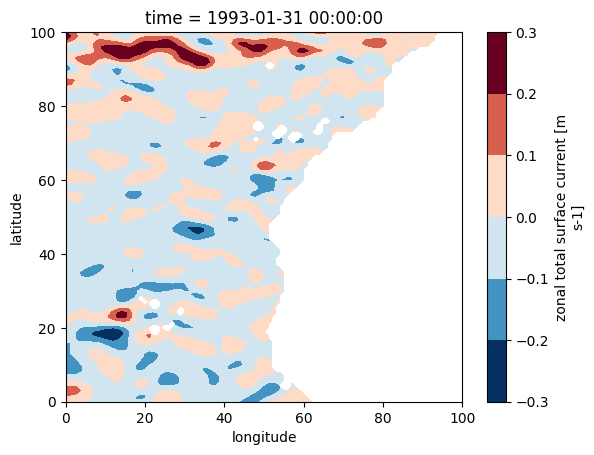

In [16]:
# x axis is longitude
u.isel(time=0).plot.contourf(x='longitude')

In [29]:
ds_sliced = ds.where((ds.lat >= 10) & (ds.lat <= 30), drop=True)
ds_sliced

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 356, lon: 1440, lat: 81)
Coordinates:
    lat      (lat) float64 648B 10.0 10.25 10.5 10.75 ... 29.25 29.5 29.75 30.0
    lon      (lon) float64 12kB ...
  * time     (time) object 3kB 1993-01-31 00:00:00 ... 2022-08-31 00:00:00
Data variables:
    u        (time, lon, lat) float64 332MB nan nan nan nan ... nan nan nan nan
    v        (time, lon, lat) float64 332MB nan nan nan nan ... nan nan nan nan
    ug       (time, lon, lat) float64 332MB nan nan nan nan ... nan nan nan nan
    vg       (time, lon, lat) float64 332MB nan nan nan nan ... nan nan nan nan
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        1993-01-01T00:00:00
    time_coverage_end:          1993-01-01T23:59:59
    date_created:               2022-01-07

## hflux

In [10]:
# hfxc
import glob

data_dir = os.path.expandvars('$WORK/data/Tropflux/monthly')
file_pattern = os.path.join(data_dir, 'netflux_tropflux_1m_????.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
netflux=ds['netflux'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin-1,ymax),time=slice(tmin,tmax))
netflux=netflux.interpolate_na(dim="longitude", method="nearest")
netflux=netflux.interpolate_na(dim="latitude", method="nearest")
netflux=netflux.bfill(dim="longitude")
netflux=netflux.bfill(dim="latitude")
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
hflx = netflux.interp(latitude=lat_xr, longitude=lon_xr).values

n = 16
hflxc = np.empty((hflx.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    hflxc[:, point_idx, :] = hflx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
hflxu=hflxc[:,:,8:]-hflxc[:,:,:8]
np.savez(f'hflx_{tmin}_2018.npz', hflxc=hflxc, hflxu=hflxu, coast=coast, lonc=lonc, latc=latc, time=time)

In [12]:
# swr
import glob

data_dir = os.path.expandvars('$WORK/data/Tropflux/monthly')
file_pattern = os.path.join(data_dir, 'swr_tropflux_1m_????.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
netflux=ds['swr'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin-2,ymax),time=slice(tmin,tmax))
netflux=netflux.interpolate_na(dim="longitude", method="nearest")
netflux=netflux.interpolate_na(dim="latitude", method="nearest")
netflux=netflux.bfill(dim="longitude")
netflux=netflux.bfill(dim="latitude")
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
hflx = netflux.interp(latitude=lat_xr, longitude=lon_xr).values

n = 16
hflxc = np.empty((hflx.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    hflxc[:, point_idx, :] = hflx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
hflxu=hflxc[:,:,8:]-hflxc[:,:,:8]
np.savez(f'swr_{tmin}_2018.npz', swrc=hflxc, hflxu=hflxu, coast=coast, lonc=lonc, latc=latc, time=time)

In [68]:
a=ds['latitude'].sel(latitude=slice(ymin, ymax)).data
b=lat.data
np.array_equal(a,b)

True

# fesom-core2-fjra

## heat budget

In [3]:
# heat_budget core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_budget_mld1_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

advx=ds['heat_advx'].groupby('time.month').mean(dim='time').values
advy=ds['heat_advy'].groupby('time.month').mean(dim='time').values
advz=ds['heat_advz'].groupby('time.month').mean(dim='time').values
diffv=ds['heat_diffv'].groupby('time.month').mean(dim='time').values
sbc=ds['heat_sbc'].groupby('time.month').mean(dim='time').values
tdc=ds['heat_tdc'].groupby('time.month').mean(dim='time').values

# also calculate the std and save it
advx_std=ds['heat_advx'].groupby('time.month').std(dim='time').values
advy_std=ds['heat_advy'].groupby('time.month').std(dim='time').values
advz_std=ds['heat_advz'].groupby('time.month').std(dim='time').values
diffv_std=ds['heat_diffv'].groupby('time.month').std(dim='time').values
sbc_std=ds['heat_sbc'].groupby('time.month').std(dim='time').values
tdc_std=ds['heat_tdc'].groupby('time.month').std(dim='time').values

n = 16  # coast band + ocean band

advx_c = np.empty((advx.shape[0], len(coast['lat']), n))
advy_c = np.empty((advy.shape[0], len(coast['lat']), n))
advz_c = np.empty((advz.shape[0], len(coast['lat']), n))
diffv_c = np.empty((diffv.shape[0], len(coast['lat']), n))
sbc_c = np.empty((sbc.shape[0], len(coast['lat']), n))
tdc_c = np.empty((tdc.shape[0], len(coast['lat']), n))

advx_c_std = np.empty((advx_std.shape[0], len(coast['lat']), n))
advy_c_std = np.empty((advy_std.shape[0], len(coast['lat']), n))
advz_c_std = np.empty((advz_std.shape[0], len(coast['lat']), n))
diffv_c_std = np.empty((diffv_std.shape[0], len(coast['lat']), n))
sbc_c_std = np.empty((sbc_std.shape[0], len(coast['lat']), n))
tdc_c_std = np.empty((tdc_std.shape[0], len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    advx_c[:, point_idx, :] = advx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c[:, point_idx, :] = advy[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c[:, point_idx, :] = advz[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c[:, point_idx, :] = diffv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c[:, point_idx, :] = sbc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c[:, point_idx, :] = tdc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advx_c_std[:, point_idx, :] = advx_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c_std[:, point_idx, :] = advy_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c_std[:, point_idx, :] = advz_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c_std[:, point_idx, :] = diffv_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c_std[:, point_idx, :] = sbc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c_std[:, point_idx, :] = tdc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

np.savez(f'heat_budget_mld1_fjra_{tmin}_{tmax}.npz',
         advx_c=advx_c, advy_c=advy_c, advz_c=advz_c,
         diffv_c=diffv_c, sbc_c=sbc_c, tdc_c=tdc_c,
         advx_c_std=advx_c_std, advy_c_std=advy_c_std, advz_c_std=advz_c_std,
         diffv_c_std=diffv_c_std, sbc_c_std=sbc_c_std, tdc_c_std=tdc_c_std,
         lono=lono, lato=lato)


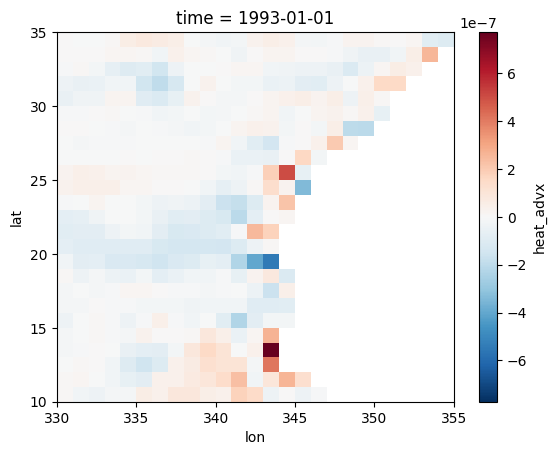

In [ ]:
ds['heat_advx'].isel(time=0).plot()

## sst

In [2]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_oce2d_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
sst=ds['sst'].values

n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_core2_fjra_sstu_m_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

## wind

In [3]:
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_forcing_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

n = 8
u = ds['tx_sur'].values
v = ds['ty_sur'].values

uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -wind_alongshore / (rho * f * distances)
# wind_alongshore_mean = wind_alongshore[:, :, 0]
# mwind_alongshore_mean_filled = np.broadcast_to(wind_alongshore_mean[:, :, np.newaxis], wind_alongshore.shape)
# etransport = -wind_alongshore_mean_filled / (rho * f * distances)

epumping = np.zeros_like(uc)  # Ensure it has the right shape and is mutable
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(uc)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    epumping[:,j,:] = 1 / (rho ) * (np.gradient(vc[:, j, :]/ f[j], x_j, axis=-1) - np.gradient(uc[:,j,:]/ f[j], dy, axis=1))

np.savez(f'fesom_core2_fjra_ekman_m_{tmin}_{tmax}.npz', windspeed=windspeed, etransport=etransport, epumping=epumping, coast=coast, lonc=lonc, latc=latc, time=time)

## heat flux

In [ ]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_forcing_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
fh=-ds['fh'].groupby('time.month').mean(dim='time').values
n = 16
fhc = np.empty((fh.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    fhc[:, point_idx, :] = fh[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
fh=fhc[:,:,8:]-fhc[:,:,:8]
np.savez(f'fesom_core2_fjra_fh_m_{tmin}_{tmax}.npz', fh=fh)

## w

In [2]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_w_mld1_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
w=ds['w_mld'].groupby('time.month').mean(dim='time').values
n = 8
wc = np.empty((w.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    wc[:, point_idx, :] = w[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
np.savez(f'fesom_core2_fjra_w_mld1_m_{tmin}_{tmax}.npz', wc=wc)

## mld

In [ ]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_oce2d_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
mld=-ds['MLD1'].groupby('time.month').mean(dim='time').values



n = 16
mldc = np.empty((mld.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    mldc[:, point_idx, :] = mld[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
np.savez(f'fesom_core2_fjra_mld1_m_{tmin}_{tmax}.npz', mldc=mldc)

## nflx_mld1

In [2]:
# core2-fjra
ds_sbc = xr.open_mfdataset('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_budget_mld1_m_1980_2023_0.25.nc')
ds_sbc['lon'] = (ds_sbc['lon'] + 360) % 360
ds_sbc = ds_sbc.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

ds_mld = xr.open_mfdataset('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_oce2d_m_1980_2023_0.25.nc')
ds_mld['lon'] = (ds_mld['lon'] + 360) % 360
ds_mld = ds_mld.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

# nflx FIRST (keeps time)
nflx = ds_sbc['heat_sbc'] * (-ds_mld['MLD1']) * 4.2e6

nflux= nflx.groupby('time.month').mean(dim='time').values
n = 16
nfluxc = np.empty((nflux.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    nfluxc[:, point_idx, :] = nflux[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
np.savez(f'fesom_core2_fjra_nflux_mld1_m_{tmin}_{tmax}.npz', nfluxc=nfluxc)

# fesom-core2-fera5

## heat budget

In [5]:
# heat_budget core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_budget_mld1_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

advx=ds['heat_advx'].groupby('time.month').mean(dim='time').values
advy=ds['heat_advy'].groupby('time.month').mean(dim='time').values
advz=ds['heat_advz'].groupby('time.month').mean(dim='time').values
diffv=ds['heat_diffv'].groupby('time.month').mean(dim='time').values
sbc=ds['heat_sbc'].groupby('time.month').mean(dim='time').values
tdc=ds['heat_tdc'].groupby('time.month').mean(dim='time').values

# also calculate the std and save it
advx_std=ds['heat_advx'].groupby('time.month').std(dim='time').values
advy_std=ds['heat_advy'].groupby('time.month').std(dim='time').values
advz_std=ds['heat_advz'].groupby('time.month').std(dim='time').values
diffv_std=ds['heat_diffv'].groupby('time.month').std(dim='time').values
sbc_std=ds['heat_sbc'].groupby('time.month').std(dim='time').values
tdc_std=ds['heat_tdc'].groupby('time.month').std(dim='time').values

n = 16  # coast band + ocean band

advx_c = np.empty((advx.shape[0], len(coast['lat']), n))
advy_c = np.empty((advy.shape[0], len(coast['lat']), n))
advz_c = np.empty((advz.shape[0], len(coast['lat']), n))
diffv_c = np.empty((diffv.shape[0], len(coast['lat']), n))
sbc_c = np.empty((sbc.shape[0], len(coast['lat']), n))
tdc_c = np.empty((tdc.shape[0], len(coast['lat']), n))

advx_c_std = np.empty((advx_std.shape[0], len(coast['lat']), n))
advy_c_std = np.empty((advy_std.shape[0], len(coast['lat']), n))
advz_c_std = np.empty((advz_std.shape[0], len(coast['lat']), n))
diffv_c_std = np.empty((diffv_std.shape[0], len(coast['lat']), n))
sbc_c_std = np.empty((sbc_std.shape[0], len(coast['lat']), n))
tdc_c_std = np.empty((tdc_std.shape[0], len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    advx_c[:, point_idx, :] = advx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c[:, point_idx, :] = advy[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c[:, point_idx, :] = advz[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c[:, point_idx, :] = diffv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c[:, point_idx, :] = sbc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c[:, point_idx, :] = tdc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advx_c_std[:, point_idx, :] = advx_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c_std[:, point_idx, :] = advy_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c_std[:, point_idx, :] = advz_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c_std[:, point_idx, :] = diffv_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c_std[:, point_idx, :] = sbc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c_std[:, point_idx, :] = tdc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

np.savez(f'heat_budget_mld1_fera5_{tmin}_{tmax}.npz',
         advx_c=advx_c, advy_c=advy_c, advz_c=advz_c,
         diffv_c=diffv_c, sbc_c=sbc_c, tdc_c=tdc_c,
         advx_c_std=advx_c_std, advy_c_std=advy_c_std, advz_c_std=advz_c_std,
         diffv_c_std=diffv_c_std, sbc_c_std=sbc_c_std, tdc_c_std=tdc_c_std,
         lono=lono, lato=lato)


## sst

In [ ]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_oce2d_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_core2_fera5_sstu_m_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

## wind

In [7]:
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_forcing_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

n = 8
u = ds['tx_sur'].groupby('time.month').mean(dim='time').values
v = ds['ty_sur'].groupby('time.month').mean(dim='time').values
curl = ds['curl_surf'].groupby('time.month').mean(dim='time').values

uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))
curlc = np.empty((curl.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    curlc[:, point_idx, :] = curl[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -wind_alongshore / (rho * f * distances)
# wind_alongshore_mean = wind_alongshore[:, :, 0]
# mwind_alongshore_mean_filled = np.broadcast_to(wind_alongshore_mean[:, :, np.newaxis], wind_alongshore.shape)
# etransport = -wind_alongshore_mean_filled / (rho * f * distances)

epumping = np.zeros_like(uc)  # Ensure it has the right shape and is mutable
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(uc)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    epumping[:,j,:] = 1 / (rho ) * (np.gradient(vc[:, j, :]/ f[j], x_j, axis=-1) - np.gradient(uc[:,j,:]/ f[j], dy, axis=1))

np.savez(f'fesom_core2_fera5_ekman_m_{tmin}_{tmax}.npz', windspeed=windspeed, etransport=etransport, epumping=epumping, coast=coast, lonc=lonc, latc=latc, time=time)

## heat flux

In [8]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_forcing_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
fh=-ds['fh'].groupby('time.month').mean(dim='time').values
n = 16
fhc = np.empty((fh.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    fhc[:, point_idx, :] = fh[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
fh=fhc[:,:,8:]-fhc[:,:,:8]
np.savez(f'fesom_core2_fera5_fh_m_{tmin}_{tmax}.npz', fh=fh)

## w_mld

In [9]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_w_mld1_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
w=ds['w_mld'].groupby('time.month').mean(dim='time').values
n = 8
wc = np.empty((w.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    wc[:, point_idx, :] = w[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
np.savez(f'fesom_core2_fera5_w_mld1_m_{tmin}_{tmax}.npz', wc=wc)

# fesom-core2-fcore2

In [19]:
# heat_budget core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-core2-budget/analysis/fesom/fesom_core2_fcore2_budget_mld1_m_1980_2009_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

advx=ds['heat_advx'].groupby('time.month').mean(dim='time').values
advy=ds['heat_advy'].groupby('time.month').mean(dim='time').values
advz=ds['heat_advz'].groupby('time.month').mean(dim='time').values
diffv=ds['heat_diffv'].groupby('time.month').mean(dim='time').values
sbc=ds['heat_sbc'].groupby('time.month').mean(dim='time').values
tdc=ds['heat_tdc'].groupby('time.month').mean(dim='time').values

# also calculate the std and save it
advx_std=ds['heat_advx'].groupby('time.month').std(dim='time').values
advy_std=ds['heat_advy'].groupby('time.month').std(dim='time').values
advz_std=ds['heat_advz'].groupby('time.month').std(dim='time').values
diffv_std=ds['heat_diffv'].groupby('time.month').std(dim='time').values
sbc_std=ds['heat_sbc'].groupby('time.month').std(dim='time').values
tdc_std=ds['heat_tdc'].groupby('time.month').std(dim='time').values

n = 16  # coast band + ocean band

advx_c = np.empty((advx.shape[0], len(coast['lat']), n))
advy_c = np.empty((advy.shape[0], len(coast['lat']), n))
advz_c = np.empty((advz.shape[0], len(coast['lat']), n))
diffv_c = np.empty((diffv.shape[0], len(coast['lat']), n))
sbc_c = np.empty((sbc.shape[0], len(coast['lat']), n))
tdc_c = np.empty((tdc.shape[0], len(coast['lat']), n))

advx_c_std = np.empty((advx_std.shape[0], len(coast['lat']), n))
advy_c_std = np.empty((advy_std.shape[0], len(coast['lat']), n))
advz_c_std = np.empty((advz_std.shape[0], len(coast['lat']), n))
diffv_c_std = np.empty((diffv_std.shape[0], len(coast['lat']), n))
sbc_c_std = np.empty((sbc_std.shape[0], len(coast['lat']), n))
tdc_c_std = np.empty((tdc_std.shape[0], len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    advx_c[:, point_idx, :] = advx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c[:, point_idx, :] = advy[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c[:, point_idx, :] = advz[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c[:, point_idx, :] = diffv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c[:, point_idx, :] = sbc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c[:, point_idx, :] = tdc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advx_c_std[:, point_idx, :] = advx_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c_std[:, point_idx, :] = advy_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c_std[:, point_idx, :] = advz_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c_std[:, point_idx, :] = diffv_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c_std[:, point_idx, :] = sbc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c_std[:, point_idx, :] = tdc_std[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

np.savez(f'heat_budget_mld1_fcore2_{tmin}_2009.npz',
         advx_c=advx_c, advy_c=advy_c, advz_c=advz_c,
         diffv_c=diffv_c, sbc_c=sbc_c, tdc_c=tdc_c,
         advx_c_std=advx_c_std, advy_c_std=advy_c_std, advz_c_std=advz_c_std,
         diffv_c_std=diffv_c_std, sbc_c_std=sbc_c_std, tdc_c_std=tdc_c_std,
         lono=lono, lato=lato)


In [18]:
advx_c.shape

(12, 100, 16)

In [2]:
# core2-fcore2
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-core2-budget/analysis/fesom/fesom_core2_fcore2_oce2d_m_1980_2009_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_core2_fcore2_sstu_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

In [ ]:
# core2-fera5
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-fera5-budget/analysis/fesom/fesom_core2_fera5_oce2d_m_1980_2022_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_core2_fera5_sstu_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

Text(0, 0.5, 'Latitude')

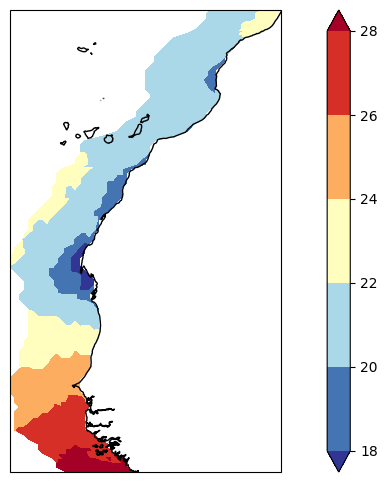

In [4]:
ff=sstc[5,:,:]

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lonc, latc, ff, cmap='RdYlBu_r', extend='both', transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)


Text(0, 0.5, 'Latitude')

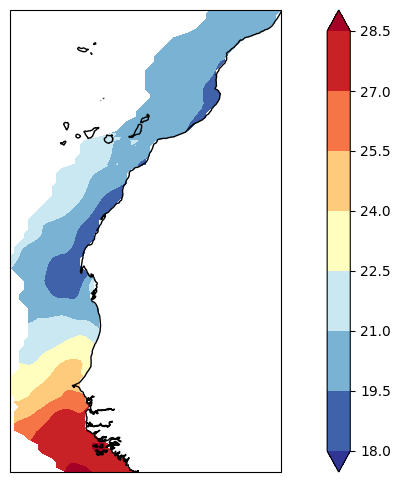

In [10]:
ff=sstc[5,:,:]

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lonc, latc, ff, cmap='RdYlBu_r', extend='both', transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)


In [ ]:
# PERU
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm

[xmin,xmax,ymin,ymax]=[270,290,-16,-6]
[tmin,tmax]=["1993","2022"] 
        
# heat_budget core2-fjra
file_path = os.path.expandvars('/gxfs_home/geomar/smomw639/FESOM/analysis/heat_budget_seasonal.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')

lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))

sst0=ds['advx'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

advx=ds['advx'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
advy=ds['advy'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
advz=ds['advz'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
diffv=ds['diffv'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
sbc=ds['sbc'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
tdc=ds['tdc'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))

n = 24  # coast band + ocean band

advx_c = np.empty((advx.shape[0], len(coast['lat']), n))
advy_c = np.empty((advy.shape[0], len(coast['lat']), n))
advz_c = np.empty((advz.shape[0], len(coast['lat']), n))
diffv_c = np.empty((diffv.shape[0], len(coast['lat']), n))
sbc_c = np.empty((sbc.shape[0], len(coast['lat']), n))
tdc_c = np.empty((tdc.shape[0], len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    advx_c[:, point_idx, :] = advx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advy_c[:, point_idx, :] = advy[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    advz_c[:, point_idx, :] = advz[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    diffv_c[:, point_idx, :] = diffv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    sbc_c[:, point_idx, :] = sbc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    tdc_c[:, point_idx, :] = tdc[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

np.savez(f'heat_budget_peru_fjra_{tmin}_{tmax}.npz',
         advx_c=advx_c, advy_c=advy_c, advz_c=advz_c,
         diffv_c=diffv_c, sbc_c=sbc_c, tdc_c=tdc_c,
         lono=lono, lato=lato)


# markus

In [4]:
# core2-fjra
file_path = os.path.expandvars('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/markus/analysis/fesom/fesom_core2_fjra_oce2d_m_1980_2023_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_core2_markus_sstu_m_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)

# fesom-tropotest-fjra

In [48]:
file_path = os.path.expandvars('/gxfs_home/geomar/smomw639/Paper1/fesom_tropotest_fjra_oce2d_m_1993_2009_0.25.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon')
ds=ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))
# calculate climological mean of sst
sst=ds['sst'].groupby('time.month').mean(dim='time').values
n = 16
sstc = np.empty((sst.shape[0],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:, point_idx, :] = sst[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc[:,:,8:]-sstc[:,:,:8]
np.savez(f'fesom_tropotest_fjra_sstu_m_{tmin}_{tmax}.npz', lon=lon, lat=lat, sstu=sstu, sstc=sstc, coast=coast, lonc=lonc, latc=latc, time=time)